<a href="https://colab.research.google.com/github/tikendraw/language-translation-model/blob/main/language_translation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Translation Model (English to Hindi)


---




In [1]:
import os, sys
if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/language-translation-model.git 
    os.chdir('language-translation-model') 
    print(os.getcwd())

Cloning into 'language-translation-model'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 11), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (28/28), 419.85 KiB | 3.59 MiB/s, done.
/content/language-translation-model


In [2]:
# Dependencies
! pip install polars -q
import polars as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention,GRU, LSTM, Bidirectional, Dense, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tensorflow_hub -q
# import tensorflow_hub as hub
import os
import re
import json
from sklearn.model_selection import train_test_split

print('Tf version: ',tf.__version__)
print('GPU: ', is_gpu:=len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if is_gpu:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 51.7 MB/s eta 0:00:00
Tf version:  2.11.0
GPU:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_url = 'http://www.manythings.org/anki/hin-eng.zip'

In [4]:
# # # Download the dataset
# if 'google.colab' in sys.modules:
#     # donwload
#     !wget $dataset_url -P dataset

#     # # Unzip the downloaded file
#     !unzip ./dataset/hin-eng.zip -d ./dataset

#     # # Show size
#     !du -h  ./dataset

# Reading the data

In [5]:
df = pd.read_csv('./dataset/hin.txt', sep = '\t', new_columns = ['english', 'hindi', 'somethingelse'])[['english','hindi']]

In [6]:
df.shape

(2908, 2)

In [7]:
df.sample(10)

english,hindi
str,str
"""Do you believe...","""क्या तुम भगवान..."
"""I had my broth...","""मैंने अपने भाई..."
"""I don't know h...","""पता नहीं कैसे ..."
"""Do you feel an...","""क्या आपको पेट ..."
"""He doesn't hav...","""उसके पास जीने ..."
"""How is it goin...","""मछली बाज़ार मे..."
"""According to T...","""टीवी समाचार के..."
"""I will get thr...","""मैं उसके आने स..."
"""She had a daug...","""उसकी अपने पहले..."


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
UNITS = 32
EMBEDDING_DIMS = 16
BATCH_SIZE = 32

# Prepare the data `tf.data`

In [10]:
# Split the data for train and val
train_df, val_df = train_test_split(df, test_size = .02, random_state = 4 )

In [11]:
print('train shape: ', train_df.shape)
print('val shape: ', val_df.shape)

train shape:  (2849, 2)
val shape:  (59, 2)


In [12]:
BUFFER_SIZE = 2000

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['english'].to_list(), train_df['hindi'].to_list())).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['english'].to_list(), val_df['hindi'].to_list())).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
len(train_ds)

90

In [15]:

# preprocessing text
def tf_lower_and_split_punct_en(text):
    # Split accented characters.
    # text = tf.text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    return text



# preprocessing text
def tf_lower_and_split_punct_hi(text):
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [16]:
some_hindi_text = 'उन्होंने मेरी का| मज़ाक उड़ाया'
print(some_hindi_text)
b= tf_lower_and_split_punct_hi(some_hindi_text)
print(b)
print(b.numpy().decode())
del(b)

उन्होंने मेरी का| मज़ाक उड़ाया
tf.Tensor(b'[START] \xe0\xa4\x89\xe0\xa4\xa8\xe0\xa5\x8d\xe0\xa4\xb9\xe0\xa5\x8b\xe0\xa4\x82\xe0\xa4\xa8\xe0\xa5\x87 \xe0\xa4\xae\xe0\xa5\x87\xe0\xa4\xb0\xe0\xa5\x80 \xe0\xa4\x95\xe0\xa4\xbe |  \xe0\xa4\xae\xe0\xa4\x9c\xe0\xa4\xbc\xe0\xa4\xbe\xe0\xa4\x95 \xe0\xa4\x89\xe0\xa4\xa1\xe0\xa4\xbc\xe0\xa4\xbe\xe0\xa4\xaf\xe0\xa4\xbe [END]', shape=(), dtype=string)
[START] उन्होंने मेरी का |  मज़ाक उड़ाया [END]


In [17]:
for i, j in train_ds.take(1):
    print('i: ',i)
    print('j: ', j)
    # print('j decoded: ',j.numpy().decode())

i:  tf.Tensor(
[b'He was destined never to meet her again.' b'I meant it as a joke.'
 b"I don't know if I'll have time to do it." b'I know his address.'
 b'She reminds me very much of her mother.' b'What is this?'
 b'We enjoyed skating.' b"I'd just like to ask Tom one question."
 b'She likes her school a lot.'
 b'There is no point in studying if you are feeling tired.'
 b'How do you feel today?' b'They went on talking for hours.'
 b'He looked back and smiled at me.' b'You made me lose my mind.'
 b'A rubber ball bounces because it is elastic.'
 b"You can't buy that kind of loyalty." b"We're all going to die someday."
 b'Are you the owner of this house?' b'Water is very important.'
 b'Do you think he will be elected president again?'
 b'This medicine will take the pain away.'
 b'Perhaps he will never be famous.'
 b"They'll fall in love with each other." b"She isn't married."
 b'Shall I clean the room?' b'The water is not drinkable.'
 b'These questions are easy to answer.' b'Is your fathe

# Text Vectorization


In [18]:
output_sequence_length = 200

In [19]:
eng_vectorizer = tf.keras.layers.TextVectorization(standardize = tf_lower_and_split_punct_en, output_sequence_length= output_sequence_length)
hin_vectorizer = tf.keras.layers.TextVectorization(standardize = tf_lower_and_split_punct_hi, output_sequence_length= output_sequence_length+1 )

In [20]:
# Adapting to textvectorizer
eng_vectorizer.adapt(train_ds.map(lambda x, y: x))
hin_vectorizer.adapt(train_ds.map(lambda x, y: y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
max_token_english = len(eng_vectorizer.get_vocabulary())
max_token_hindi = len(hin_vectorizer.get_vocabulary())

print('Maxtokens:')
print( 'English : ', max_token_english)
print('Hindi: ', max_token_hindi)

Maxtokens:
English :  2359
Hindi:  3016


In [22]:
print('Text: ',some_hindi_text)
print('\nEncoded text: ,')
hin_vectorizer(some_hindi_text)

Text:  उन्होंने मेरी का| मज़ाक उड़ाया

Encoded text: ,


<tf.Tensor: shape=(201,), dtype=int64, numpy=
array([   2,  173,   40,   20, 1446,  369,    1,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

## Mapping Vectorizer to dataset

In [23]:
BATCH_SIZE = 32

In [24]:
def make_vec(x, y ):
    x, y = eng_vectorizer(x), hin_vectorizer(y)

    y_in = y[:,:-1]
    y_out = y[:,1:]
    return (x,y_in), y_out

In [25]:
train_ds = train_ds.map(make_vec) #.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(make_vec) # .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
for i,j in val_ds.take(1):
    print(i[1])
    print()
    print(j)
    break

tf.Tensor(
[[   2    9    1 ...    0    0    0]
 [   2   52  122 ...    0    0    0]
 [   2  591  155 ...    0    0    0]
 ...
 [   2    9    1 ...    0    0    0]
 [   2   12 1406 ...    0    0    0]
 [   2   12    1 ...    0    0    0]], shape=(32, 200), dtype=int64)

tf.Tensor(
[[   9    1   22 ...    0    0    0]
 [  52  122  127 ...    0    0    0]
 [ 591  155  443 ...    0    0    0]
 ...
 [   9    1   42 ...    0    0    0]
 [  12 1406   89 ...    0    0    0]
 [  12    1    1 ...    0    0    0]], shape=(32, 200), dtype=int64)


# Model

## Encoder

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units, embedding_dims = 32):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        # self.return_state = return_state
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.LSTM(units, 
                                       return_sequences = True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform'))

    def call(self, x):

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)

        # 3. The GRU processes the sequence of embeddings.
        *x, state_h, state_c = self.rnn(x)
        tf.print('after encoder return sequence true: ',len(x) )
        state = [state_h, state_c]
    
        return x, state

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts)
        context = self(context)
        return context

## Attention

In [28]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

## Decoder

In [29]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, embedding_dims = 32):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.LSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### Decoder call

In [30]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  

    # 1. Lookup the embeddings
    x = self.embedding(x)

    # 2. Process the target sequence.
    x = self.rnn(x, initial_state=state)
    tf.print('decoder output: ', len(x))
    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights


    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)

    if return_state:
        return logits, state
    else:
        return logits

In [31]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [32]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [33]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(context, next_token, state = state, return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [34]:
# class Translator(tf.keras.Model):
#     @classmethod
#     def add_method(cls, fun):
#         setattr(cls, fun.__name__, fun)
#         return fun

#     def __init__(self, units, context_text_processor, target_text_processor):
#         super().__init__()
#         # Build the encoder and decoder
#         encoder = Encoder(context_text_processor, units)
#         decoder = Decoder(target_text_processor, units)

#         self.encoder = encoder
#         self.decoder = decoder
        

#     def call(self, inputs):
#         context, x = inputs
#         tf.print('Before encoder-decoder')
#         # tf.print('inputs : ',inputs.shape)
#         tf.print('context: ',context.shape)
#         tf.print('x      : ',x.shape)
#         context = self.encoder(context)
#         tf.print()
#         logits = self.decoder(context, x)
#         tf.print('--'*20)
#         tf.print('After encoder-decoder')
#         tf.print('context: ',context.shape)
#         tf.print('logits : ',logits.shape)
#     #TODO(b/250038731): remove this
#         try:
#           # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
#             del logits._keras_mask
#         except AttributeError:
#             pass

#         return logits

In [172]:
class Translator2(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        
        self.context_text_processor = context_text_processor
        self.target_text_processor = target_text_processor

        self.context_vocab_size = context_text_processor.vocabulary_size()
        self.target_vocab_size = target_text_processor.vocabulary_size()
        
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
    
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding1 = tf.keras.layers.Embedding(self.context_vocab_size, units, mask_zero=True)
        self.embedding2 = tf.keras.layers.Embedding(self.target_vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.encoder = tf.keras.layers.Bidirectional(
            merge_mode='concat',
            layer=tf.keras.layers.GRU(units, 
                                       return_sequences = True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform'))
        
        self.decoder = GRU(units, 
                                       return_sequences = True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform')
        
        
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)
        self.last_attention_weights = None
        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.target_vocab_size)
        
        self.encoder_state = None
    def call(self, X, y=None):
        context, que = X
        
        #Encoding
        # 1. embedding
        x = self.embedding1(context)
        # tf.print('after embedding: x shape: ',x.shape )
        encoder_context, enc_h, enc_c = self.encoder(x)
        self.encoder_state = [enc_h, enc_c]
        # tf.print('after encodeing: x shape: ',len(x) )

        # encoder_context, encoder_state = x
        #Decoding
        x = self.embedding2(que)
        decoder_context, decoder_state_h, decoder_state_c = self.decoder(x, initial_state=self.encoder_state)
        
        x = self.attention(decoder_context, encoder_context)
        # self.last_attention_weights = self.attention.last_attention_weights
        # tf.print('decoder context shape: ', len(decoder_context))
        # logits
        logits = self.output_layer(x)
            # tf.print('\n')
        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [173]:
model = Translator2(UNITS, eng_vectorizer, hin_vectorizer)

In [174]:
#@title
# sample = train_df.sample(5)
# some_hindi_text = sample['hindi'].to_numpy()
# some_eng_text = sample['english'].to_numpy()

# print(some_hindi_text)
# print(some_eng_text)

# vectorized_eng_text = eng_vectorizer(some_eng_text)
# vectorized_eng_text[:,:10]

# vectorized_hindi_text = hin_vectorizer(some_hindi_text)
# vectorized_hindi_text[:,:10]

# vec_hindi_in = vectorized_hindi_text[:,:-1]
# vec_hindi_out = vectorized_hindi_text[:,1:]
# print(vec_hindi_in[:,:10])
# print()
# print(vec_hindi_out[:,:10])

# encoder = Encoder(eng_vectorizer, UNITS)
# # context_eng = encoder((vectorized_eng_text))

# new_tx = encoder.convert_input(['hey man'])

# # context_eng

# # decoder = Decoder(hin_vectorizer, UNITS)
# # logits = decoder(context_eng, vec_hindi_in)
# # logits.shape

In [175]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [176]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [177]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [178]:
# model.summary()

In [179]:
EPOCHS = 50
CKPT_DIR = './model_checkpoint'

In [180]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(CKPT_DIR,  f"{datetime.now().strftime('%m:%d:%Y, %H:%M:%S')}"),
    monitor= 'loss',
    verbose= 0,
    save_best_only = True,
    save_weights_only = True,
    mode= 'auto',
    save_freq='epoch'
)

In [181]:
data_amount = 20

In [182]:
# tf.executing_eagerly(False)

history = model.fit(
    train_ds.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch = int(data_amount*(len(train_ds)/EPOCHS)),

    validation_data=val_ds.repeat(),
    validation_steps = 5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor = 'masked_loss', patience=3),
    model_ckpt])

Epoch 1/50


ValueError: ignored

In [ ]:
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [183]:
class Inference():

    def __init__(self,model ):
        self.model = model

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.model.context_text_processor(texts)
        context = self.model.embedding1(context)
        context, enc_h, enc_c = self.model.encoder(context)
        # state = [enc_h, enc_c]
        return context

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.model.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.model.embedding2(start_tokens)
        # context = tf.zeros([batch_size, self.model.units], tf.float32)
        context = self.model.decoder.get_initial_state(embedded)[0]
        return start_tokens, done, context 


    def tokens_to_text(self, tokens):
        words = self.model.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result


    def get_next_token(self, context, next_token, done, state, temperature = 0.0):
        logits, state = self.model.decoder(
        context, next_token,
        state = state,
        return_state=True) 
    
        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (next_token == self.model.end_token)
        # Once a sequence is done it only produces 0-padding.
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state


    def translate(self,
              texts,
              max_length=50,
              temperature=0.0):
    # Process the input texts
        
        context = self.convert_input(texts)
        print('first: ',context.shape)
        batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
        tokens = []
        # attention_weights = []
        next_token, done, state = self.get_initial_state(context)

        for _ in range(max_length):
            # Generate the next token
            next_token, done, state = self.get_next_token(context, next_token, done,  state, temperature)

            # Collect the generated tokens
            tokens.append(next_token)
            # attention_weights.append(self.last_attention_weights)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Stack the lists of tokens and attention weights.
        tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
        # self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

        result = self.tokens_to_text(tokens)
        return result

In [184]:
inf = Inference(model)

In [185]:
ss = inf.translate(['She loves me'])
ss

first:  (1, 200, 64)


ValueError: ignored

In [134]:
ss = convert_input([['hello'], ['hwy']])
for i in ss:
    print(i.shape)

(2, 200, 64)
(2, 32)
(2, 32)


In [117]:
a = [['hello how  are you'],['hey'],[ 'who are you']]
aa = tf.convert_to_tensor(a)
aa

<tf.Tensor: shape=(3, 1), dtype=string, numpy=
array([[b'hello how  are you'],
       [b'hey'],
       [b'who are you']], dtype=object)>

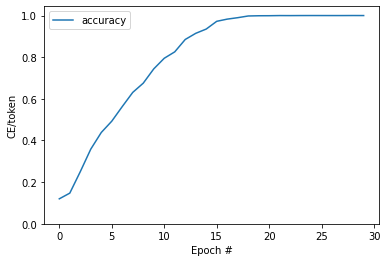

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
# plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
result = model.translate(['She loves me']) 
result[0].numpy().decode()

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.ylim([0, max(plt.ylim())])
plt.title('accuracy vs epochs')
plt.legend()